# Домашнее задание 3. Алгоритмы кластеризации

Основная задача этого задания -- реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [44]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from scipy.stats import multivariate_normal as gaussian
from numpy import linalg as LA
from sklearn import cluster
# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Cчитываем данные, полученные в результате выполнения предыдущего домашнего задания, в `data frame` библиотеки `pandas`. Конвертируем данные в массив `numpy`.

In [45]:
data_df = pd.read_csv("hw2_out.csv", sep="\t", header=0, index_col="twitter_id")
x = data_df.values

data_df.head()

,followers_count,friends_count,statuses_count,favourites_count,listed_count,created_year,name_words,screen_name_length,description_length
twitter_id,,,,,,,,,
66412773,0.517354,0.641639,0.842635,0.520354,0.493751,0.111111,0.416667,0.96875,0.25
10143902,0.446893,0.530175,0.468081,0.315955,0.419829,0.111111,0.666667,0.48125,0.00
73701917,0.492488,0.389437,0.760603,0.542262,0.342905,0.222222,0.166667,0.34375,0.25
82209363,0.374736,0.469622,0.659542,0.724335,0.072952,0.111111,0.916667,0.39375,0.25
47063951,0.522846,0.630204,0.722684,0.844944,0.320427,0.222222,0.583333,0.86875,0.25


Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего логина на портале Техносферы.

In [46]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("p02p") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [68]:
class Clustering:
    """
    Implement clustering algorithm according
    """

    def __init__(self, k, max_iter=1000, eps=1e-2, max_exec = 4, min_cov=1e-3):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self.k = k # Количество кластеров
        self.__max_iter = max_iter # Максимальное количество итераций в em
        self.__eps = eps # Условие останова
        self.__max_exec = max_exec # Максимальное количество попыток выполнить, при том что программа "падает" из-за инициализации
        self.__min_cov = min_cov # Если матрица вырожденная - добавляем матрицу с таким элементом по диагонали

        return

    def __init_params__(self, x_dimen, x_len, x):
        """
        Начальное приближение
        """
        
        # Мат ожидание с помощью K-means
        #self.__m = np.zeros([self.k, x_dimen])
        self.__m = cluster.KMeans( \
                    n_clusters=self.k, \
                    random_state=5).fit(x).cluster_centers_

        # Случайным образом дисперсию. - симметричную матрицу
        self.__d = np.zeros([self.k, x_dimen, x_dimen])
        for i in range(self.k):
            n=100 # Количество точек в каждом векторе
            vals=[]
            for _ in range(x_dimen):
                vals.append(np.random.normal(size=n))
            self.__d[i]=np.cov(vals)

        # Случайным образом априорные вероятности, при том что их сумма = 1
        self.__p = np.array([random.random() for i in range(self.k)])
        self.__p /= np.sum(self.__p)

        # Нулями y
        self.__y = np.zeros([x_len, self.k])
        
        
    def __is_singular(self, a):
        return a.shape[0] == a.shape[1] and np.linalg.matrix_rank(a) == a.shape[0]
        
        
        
        
    def fit(self, x, y=None):
        
        # Количество точек
        x_count = len(x)

        # Размерность каждой точки
        x_dimen = x.shape[1]

        # Инициализируем параметры
        self.__init_params__(x_dimen, x_count, x)
        
        last_norm = 0;
        new_norm = self.__eps + 1;
        n_iter = -1
        
        while ( \
               (abs(last_norm - new_norm) > self.__eps) \
               and (self.__max_iter > n_iter) \
              ):
        
            # Обновляем критерии останова
            n_iter += 1
            last_norm = LA.norm(self.__y)
            
            # E - step
            for i in range(x_count):
                p_full = 0 # Полная вероятность выпадения x[i]
                for j in range(self.k):
                    p_full += self.__p[j] * gaussian.pdf(x[i], mean=self.__m[j], cov=self.__d[j])
                for j in range(self.k):
                    self.__y[i][j] = self.__p[j] * gaussian.pdf(x[i], mean=self.__m[j], cov=self.__d[j])/p_full;
            
            
            new_norm = LA.norm(self.__y)
            print "N_clu={}, Diff = {}, iter = {}".format(self.k, last_norm - new_norm, n_iter)
            
            # M - step
            N = np.zeros(self.k)
            
            for j in range(self.k):
                N[j] = np.sum(self.__y[:,j]) # суммируем столбец

                # Вычисляем математическое ожидание
                self.__m[j] = np.zeros(x_dimen)
                for i in range(x_count):
                    self.__m[j] += self.__y[i][j]*x[i]
                self.__m[j] = self.__m[j]/N[j]
                
                
                # Вычисляем дисперсию (матрицу ковариации)
                self.__d[j] = np.zeros([x_dimen, x_dimen])
                for i in range(x_count):
                    mat_2 = np.mat((x[i]-self.__m[j]))
                    mat_1 = mat_2.T
                    self.__d[j] += self.__y[i][j]*(mat_1*mat_2)
                self.__d[j] = self.__d[j]/N[j]
                
                if LA.det(self.__d[j]) < 1e-20:
                    print "Вырожденная"
                    self.__d[j]+=np.mat(np.diag([self.__min_cov]*x_dimen))
                
                # Вычисляем абсолютную вероятность кластера
                self.__p[j] = N[j]/self.k
                
        return self


    def __fit(self, x, y=None):
        """
        Иногда, из-а того что данные случайные, получается вырожденная матрица.
        Если матрица вырожденная - перезапускаем алгоритм
        """
#        exec_count = 0
#        while(exec_count < self.__max_exec):
        try:
            self.__em_algorithm(x)
            return self
        except LA.LinAlgError as err:
            print ("Вырожденная матрица!")
            #return self
#            exec_count += 1
                
        return self # Если не досчитал - возвращаем, что осталось


    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        result = np.zeros(len(x), dtype=numpy.int)
        
        # По нашей модели считаем вероятность кластера для каждого элемента вектора. Складываем индексы полученых кластеров
        for i in range(len(x)):
            
            y = [0]*self.k
            
            p_full = 0
            for j in range(self.k):
                p_full += self.__p[j] * gaussian.pdf(x[i], mean=self.__m[j], cov=self.__d[j])
            for j in range(self.k):
                y[j] = self.__p[j] * gaussian.pdf(x[i], mean=self.__m[j], cov=self.__d[j])/p_full;
            
            result[i] = y.index(max(y))
            
        return result

    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)


Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

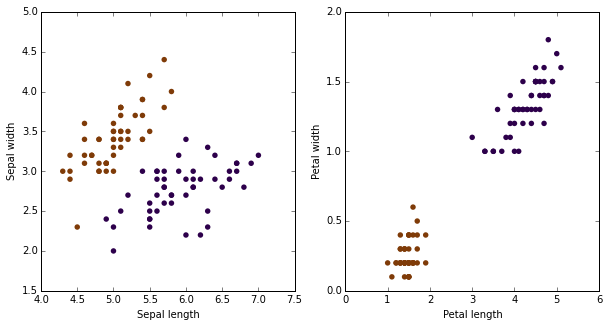

In [69]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [74]:
from sklearn.cluster import KMeans
"""
kmean = KMeans(init='random', n_clusters=2)
pred_iris = kmean.fit_predict(x_iris)
"""

pred_iris = Clustering(2).fit_predict(x_iris)
"""
from sklearn import mixture
g = mixture.GMM(n_components=2, random_state=5)
g.fit(x_iris)
pred_iris = g.predict(x_iris)

"""
print "y="
print y_iris
print "pred_iris="
print pred_iris


print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

N_clu=2, Diff = -9.74214007231, iter = 0
N_clu=2, Diff = -0.209289433824, iter = 1
N_clu=2, Diff = -0.0485694506234, iter = 2
N_clu=2, Diff = -1.04321367189e-06, iter = 3
y=
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
pred_iris=
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Adjusted Rand index for iris is: 1.00


In [11]:
def quality(x, y):
    # Реализуем инерцию
    """
    Implement quality criterion of your choice
    """
    # Для каждого кластера считаем координаты центроида.
    k = max(y)+1 # Количество кластеров
    centroid = np.zeros([k, x.shape[1]]) # Координаты центроида
    for i in range(len(x)):
        centroid[y[i]] += x[i]
    
    for i in range(k):
        centroid[i] /= (y==i).sum()
    
    print(centroid)
    # Расстояние каждой точки до ближайшего кластера
    x_in = np.zeros(len(x))
    for i in range(len(x)):
        i_c_distance = np.zeros(k) # Расстояние от точки i до кластера j
        for j in range(k):
            i_c_distance[j] = np.sum((x[i]-centroid[j]**2))
        x_in = i_c_distance.min()
        
    return x_in.sum()

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

In [13]:
ks = range(1, 7)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = Clustering(k)
    _x = x[:300]
    y = cls.fit_predict(_x)
    criteria[i] = quality(_x, y)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

N_clu=1, Diff = -17.3205080757, iter = 0
N_clu=1, Diff = 0.0, iter = 1
[[ 0.41429187  0.48694708  0.52930977  0.44568942  0.16846815  0.11444444
   0.71027778  0.48122917  0.49708333]]
N_clu=2, Diff = -12.4500348872, iter = 0
N_clu=2, Diff = -0.0775831169074, iter = 1
N_clu=2, Diff = -0.652708891575, iter = 2
N_clu=2, Diff = -1.23752902116, iter = 3
N_clu=2, Diff = -0.989318442985, iter = 4
N_clu=2, Diff = -0.510759337253, iter = 5
N_clu=2, Diff = -0.237506114811, iter = 6
N_clu=2, Diff = -0.119984909603, iter = 7
N_clu=2, Diff = -0.0712661052617, iter = 8
N_clu=2, Diff = -0.0432161931472, iter = 9
N_clu=2, Diff = -0.0234007472105, iter = 10
N_clu=2, Diff = -0.0260339136611, iter = 11
N_clu=2, Diff = -0.026424183222, iter = 12
N_clu=2, Diff = -0.0250198951333, iter = 13
N_clu=2, Diff = -0.0104606881847, iter = 14
N_clu=2, Diff = -0.00757809679346, iter = 15
N_clu=2, Diff = -0.00576546734261, iter = 16
N_clu=2, Diff = -0.00412434272874, iter = 17
N_clu=2, Diff = -0.00280436122631, iter 

KeyboardInterrupt: 

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

In [201]:
k = 5
cls = Clustering(k)
y = cls.fit_predict(x)

N_clu=5, Diff = -36.5630325929, iter = 0
N_clu=5, Diff = -0.133735055992, iter = 1
N_clu=5, Diff = -2.1136510438, iter = 2
N_clu=5, Diff = -4.41530739323, iter = 3
N_clu=5, Diff = -2.6085059654, iter = 4
N_clu=5, Diff = -1.21840079148, iter = 5
N_clu=5, Diff = -0.630660507043, iter = 6
N_clu=5, Diff = -0.479434416367, iter = 7
N_clu=5, Diff = -0.357214977839, iter = 8
N_clu=5, Diff = -0.213940478468, iter = 9
N_clu=5, Diff = -0.159231383857, iter = 10
N_clu=5, Diff = -0.205671804299, iter = 11
N_clu=5, Diff = -0.23862078447, iter = 12
Вырожденная
N_clu=5, Diff = 0.74308255005, iter = 13
N_clu=5, Diff = 0.163632664364, iter = 14
N_clu=5, Diff = -0.0617394517903, iter = 15


In [188]:
from sklearn.cluster import KMeans
kmean = KMeans(init='random', n_clusters=5)
kmean.fit_predict(x)

array([4, 2, 3, ..., 0, 4, 1], dtype=int32)

Визуализируем результаты кластеризации ([подсказка](http://anokhin.github.io/img/hw3_tsne-kmeans.png)). Можно ли сказать, что в двумерном пространстве объекты из одного кластера находятся недалеко? Какой вывод можно сделать о качестве кластеризации?

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.137730
[t-SNE] Error after 83 iterations with early exaggeration: 19.999844
[t-SNE] Error after 321 iterations: 2.129082


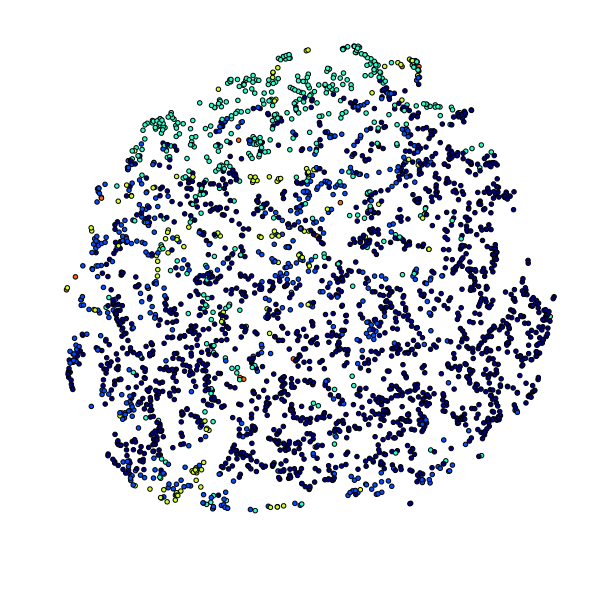

In [202]:
tsne = sm.TSNE(n_components=2, verbose=1, n_iter=1000)
z = tsne.fit_transform(x)

# Color map
cm = pl.get_cmap('jet')
pl.figure(figsize=(10, 10))
pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * c / k), y))
pl.axis('off')
pl.show()

Попробуем проанализировать полученные кластеры. Для того, чтобы интерпретировать "суть" каждого из кластеров, построим [radar plot](http://www.wikiwand.com/en/Radar_chart), отображающий их центроиды. Посмотрите на графики и попробуйте объяснить, каким поведением можно охарактеризовать каждый из полученных кластеров? Есть ли среди кластеров похожие?

Реализация радара позаимствована отсюда: 
http://www.science-emergence.com/Matplotlib/MatplotlibGallery/RadarChartMatplotlibRougier/

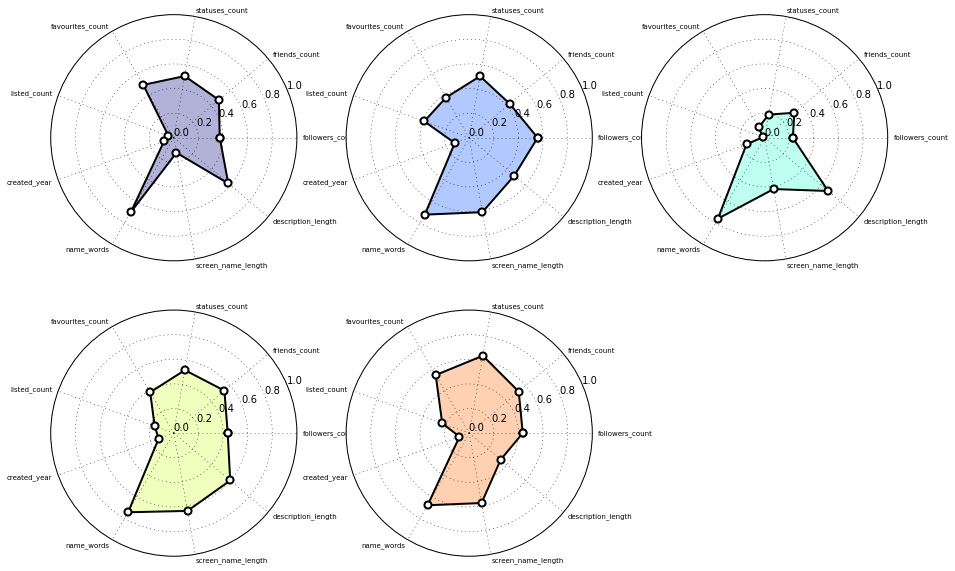

In [169]:
def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

clusters = np.unique(y)
for j, cluster in enumerate(clusters):    
    x_c = x[y == cluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(3, 3, j + 1, polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / k))

plt.show()

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.